### Connect to Duckdb and Inspect Database Schema


In [1]:
import duckdb

with duckdb.connect("data/sakila.duckdb") as conn:
    desc = conn.sql("DESC;").df()
desc

,database,schema,name,column_names,column_types,temporary
0,sakila,staging,_dlt_loads,"[load_id, schema_name, status, inserted_at, sc...","[VARCHAR, VARCHAR, BIGINT, TIMESTAMP WITH TIME...",False
1,sakila,staging,_dlt_pipeline_state,"[version, engine_version, pipeline_name, state...","[BIGINT, BIGINT, VARCHAR, VARCHAR, TIMESTAMP W...",False
2,sakila,staging,_dlt_version,"[version, engine_version, inserted_at, schema_...","[BIGINT, BIGINT, TIMESTAMP WITH TIME ZONE, VAR...",False
3,sakila,staging,actor,"[actor_id, first_name, last_name, last_update,...","[DECIMAL(38,9), VARCHAR, VARCHAR, TIMESTAMP, V...",False
4,sakila,staging,address,"[address_id, address, address2, district, city...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, VA...",False
5,sakila,staging,category,"[category_id, name, last_update, _dlt_load_id,...","[BIGINT, VARCHAR, TIMESTAMP, VARCHAR, VARCHAR]",False
6,sakila,staging,city,"[city_id, city, country_id, last_update, _dlt_...","[BIGINT, VARCHAR, BIGINT, TIMESTAMP, VARCHAR, ...",False
7,sakila,staging,country,"[country_id, country, last_update, _dlt_load_i...","[BIGINT, VARCHAR, TIMESTAMP, VARCHAR, VARCHAR]",False
8,sakila,staging,customer,"[customer_id, store_id, first_name, last_name,...","[BIGINT, BIGINT, VARCHAR, VARCHAR, VARCHAR, BI...",False
9,sakila,staging,film,"[film_id, title, description, release_year, la...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, BI...",False


### Load and Register Tables from Duckdb Staging

In [2]:
la = {}
with duckdb.connect("data/sakila.duckdb") as conn:
    for name in desc["name"]:
        la[name] = conn.sql(f"FROM staging.{name};").df()
        duckdb.register(name, la[name])
        


## Task 1 - EDA in python

### a) Which movies are longer than 3 hours (180 minutes), show the title and its length?

In [3]:
la['film'].head(3)

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,_dlt_load_id,_dlt_id
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,<NA>,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2021-03-06 15:52:00,1765282237.85467,8UeHo0d4NsKrhQ
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,<NA>,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2021-03-06 15:52:00,1765282237.85467,U985ypLic88u7A
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,<NA>,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2021-03-06 15:52:00,1765282237.85467,qxu5GG1U0R7RUQ


In [4]:
duckdb.sql("SELECT title, length FROM film WHERE length > 180 ORDER BY length;").df()

,title,length
0,LAWLESS VISION,181
1,WILD APOLLO,181
2,STAR OPERATION,181
3,RUNAWAY TENENBAUMS,181
4,ANALYZE HOOSIERS,181
5,HAUNTING PIANIST,181
6,LOVE SUICIDES,181
7,HOTEL HAPPINESS,181
8,INTRIGUE WORST,181
9,JACKET FRISCO,181


### b) Which movies have the word "love" in its title? Show the following columns title, rating, length, description

In [5]:
duckdb.sql("SELECT title, rating, length, description FROM film WHERE title ILIKE '%love%' ORDER BY length DESC;").df()

,title,rating,length,description
0,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...
1,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
2,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
3,LOVERBOY ATTACKS,PG-13,162,A Boring Story of a Car And a Butler who must ...
4,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
5,IDENTITY LOVER,PG-13,119,A Boring Tale of a Composer And a Mad Cow who ...
6,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
7,STRANGELOVE DESIRE,NC-17,103,A Awe-Inspiring Panorama of a Lumberjack And a...
8,LOVER TRUMAN,G,75,A Emotional Yarn of a Robot And a Boy who must...
9,LOVELY JINGLE,PG,65,A Fanciful Yarn of a Crocodile And a Forensic ...


### c) Calculate descriptive statistics on the length column, The Manager wants, shortest, average, median and longest movie length

In [6]:
duckdb.sql("SELECT MIN(length) AS min_length_minutes, ROUND(AVG(length)) AS avg_length_minutes, MEDIAN(length) AS mean_length_minutes, MAX(length) AS max_length_minutes FROM film; ").df()

,min_length_minutes,avg_length_minutes,mean_length_minutes,max_length_minutes
0,46,115.0,114.0,185


 ### d) The rental rate is the cost to rent a movie and the rental duration is the number of days a customer can keep the movie.
 ### The Manager wants to know the 10 most expensive movies to rent per day.

In [7]:
la["film"].head(1)

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,_dlt_load_id,_dlt_id
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,<NA>,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2021-03-06 15:52:00,1765282237.85467,8UeHo0d4NsKrhQ


In [8]:
duckdb.sql("SELECT title, rental_rate/rental_duration AS rate_per_day FROM film ORDER BY rate_per_day DESC LIMIT 10;").df()

,title,rate_per_day
0,AMERICAN CIRCUS,1.663333
1,BACKLASH UNDEFEATED,1.663333
2,BILKO ANONYMOUS,1.663333
3,BEAST HUNCHBACK,1.663333
4,CARIBBEAN LIBERTY,1.663333
5,AUTUMN CROW,1.663333
6,CASPER DRAGONFLY,1.663333
7,ACE GOLDFINGER,1.663333
8,BEHAVIOR RUNAWAY,1.663333
9,CASUALTIES ENCINO,1.663333


### e) Which actors have played in most movies? Show the top 10 actors with the number of movies they have played in.

In [9]:
duckdb.sql("SELECT  a.first_name || ' ' || a.last_name AS actor_name, COUNT( distinct fa.film_id) AS total_films FROM actor a LEFT JOIN film_actor fa ON a.actor_id = fa.actor_id GROUP BY  actor_name  ORDER BY total_films DESC LIMIT 10;").df()

,actor_name,total_films
0,SUSAN DAVIS,54
1,GINA DEGENERES,42
2,WALTER TORN,41
3,MARY KEITEL,40
4,MATTHEW CARREY,39
5,SANDRA KILMER,37
6,SCARLETT DAMON,36
7,ANGELA WITHERSPOON,35
8,VIVIEN BASINGER,35
9,HENRY BERRY,35


### 1) Identify the titles of the top 3 films that have the highest total revenue  but were rented the least number of times overall .
### Show the film title, the total_revenue, and the rental_count.


In [10]:
duckdb.sql("SELECT f.title, SUM(p.amount) AS total_revenue, COUNT(r.rental_id) AS rental_count FROM film f LEFT JOIN inventory i ON f.film_id = i.film_id LEFT JOIN rental r ON i.inventory_id = r.inventory_id LEFT JOIN payment p ON r.rental_id = p.rental_id GROUP BY f.title ORDER BY total_revenue DESC, rental_count ASC LIMIT 3;").df()

,title,total_revenue,rental_count
0,TELEGRAPH VOYAGE,231.73,27
1,WIFE TURN,223.69,31
2,ZORRO ARK,214.69,31


### 2) Identify the top 5 film categories that have the highest average replacement cost for their films,
### but currently have the lowest average number of copies in inventory across all stores.
### Show the category_name, the average_replacement_cost, and the average_inventory_count.


In [11]:
duckdb.sql("SELECT c.name AS category_name, ROUND(AVG(f.replacement_cost)) AS avg_replacement_cost, ROUND(COUNT(i.inventory_id)/ COUNT(DISTINCT f.film_id)) AS avg_inventory_count FROM category c LEFT JOIN film_category fc ON c.category_id = fc.category_id LEFT JOIN film f ON fc.film_id = f.film_id LEFT JOIN inventory i ON f.film_id = i.film_id GROUP BY category_name ORDER BY avg_replacement_cost DESC, avg_inventory_count ASC LIMIT 5;").df()

,category_name,avg_replacement_cost,avg_inventory_count
0,Drama,22.0,5.0
1,Documentary,21.0,4.0
2,Games,21.0,5.0
3,Classics,21.0,5.0
4,Sci-Fi,21.0,5.0


### 3) Which customers return movies the fastest on average?

In [12]:
la["rental"].head(3)

,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update,_dlt_load_id,_dlt_id
0,1,2005-05-24 22:53:30,367,130,2005-05-26 22:04:30,1,2021-03-06 15:53:41,1765282237.85467,IqQgQcAWHrwSjw
1,2,2005-05-24 22:54:33,1525,459,2005-05-28 19:40:33,1,2021-03-06 15:53:41,1765282237.85467,HmRSO96cjtCChA
2,3,2005-05-24 23:03:39,1711,408,2005-06-01 22:12:39,1,2021-03-06 15:53:41,1765282237.85467,5jF125SeMYkSFw


In [13]:
duckdb.sql("DESC rental;").df()

,column_name,column_type,null,key,default,extra
0,rental_id,BIGINT,YES,None,None,None
1,rental_date,TIMESTAMP,YES,None,None,None
2,inventory_id,BIGINT,YES,None,None,None
3,customer_id,BIGINT,YES,None,None,None
4,return_date,TIMESTAMP,YES,None,None,None
5,staff_id,BIGINT,YES,None,None,None
6,last_update,TIMESTAMP,YES,None,None,None
7,_dlt_load_id,VARCHAR,YES,None,None,None
8,_dlt_id,VARCHAR,YES,None,None,None


In [14]:
duckdb.sql("SELECT c.customer_id, c.first_name || ' ' || c.last_name AS customer_name, ROUND(AVG(date_diff('day', r.rental_date , r.return_date))) AS avg_rental_duration, COUNT(r.rental_id) AS total_rentals FROM customer c JOIN rental r ON c.customer_id = r.customer_id WHERE r.return_date IS NOT NULL GROUP BY c.customer_id, customer_name ORDER BY avg_rental_duration, customer_name LIMIT 5;").df()


,customer_id,customer_name,avg_rental_duration,total_rentals
0,167,SALLY PIERCE,3.0,32
1,568,ALBERTO HENNING,4.0,20
2,152,ALICIA MILLS,4.0,20
3,228,ALLISON STANLEY,4.0,25
4,81,ANDREA HENDERSON,4.0,22


### ASSIGNING TO A VARIABALE AND TRASFER TO "REFINED" SCHEMA 

In [15]:
customer_rental_duration = duckdb.sql("SELECT c.customer_id, c.first_name || ' ' || c.last_name AS customer_name, ROUND(AVG(date_diff('day', r.rental_date , r.return_date))) AS avg_rental_duration, COUNT(r.rental_id) AS total_rentals FROM customer c JOIN rental r ON c.customer_id = r.customer_id WHERE r.return_date IS NOT NULL GROUP BY c.customer_id, customer_name ORDER BY avg_rental_duration, customer_name;").df()


In [16]:
duckdb.sql("""
            CREATE SCHEMA IF NOT EXISTS refined;
           
           CREATE OR REPLACE TABLE refined.customer_rental_duration AS 
           SELECT * FROM customer_rental_duration;
""")

In [17]:
duckdb.sql("DESCRIBE refined.customer_rental_duration").df()



,column_name,column_type,null,key,default,extra
0,customer_id,BIGINT,YES,None,None,None
1,customer_name,VARCHAR,YES,None,None,None
2,avg_rental_duration,DOUBLE,YES,None,None,None
3,total_rentals,BIGINT,YES,None,None,None


### Bar chart with top 10 fastest returners

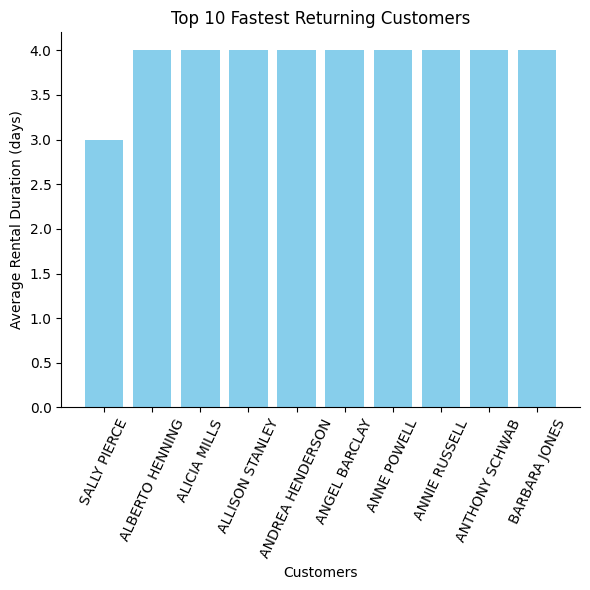

In [18]:
import matplotlib.pyplot as plt

df_chart1 = customer_rental_duration.head(10)

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(df_chart1['customer_name'], df_chart1['avg_rental_duration'], color='skyblue')
ax.set_xlabel('Customers')
ax.set_ylabel('Average Rental Duration (days)')
ax.set_title('Top 10 Fastest Returning Customers')
ax.tick_params(axis='x', rotation=65)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig("customer_rental_duration_top10.png", dpi=100, bbox_inches='tight')

plt.tight_layout()
plt.show()



### 4) Which actors have the highest average rental duration for the movies they star in?

In [19]:
duckdb.sql("SELECT (a.actor_id:: INT) AS actor_id, a.first_name || ' ' || a.last_name AS actor_name, COUNT(fa.film_id) AS total_films, ROUND(AVG(date_diff('day' , r.rental_date, r.return_date))) AS avg_rental_duration_days FROM actor a LEFT JOIN film_actor fa ON a.actor_id = fa.actor_id LEFT JOIN film f ON fa.film_id = f.film_id LEFT JOIN inventory i ON f.film_id = i.film_id LEFT JOIN rental r ON i.inventory_id = r.inventory_id GROUP BY a.actor_id, actor_name ORDER BY avg_rental_duration_days DESC, actor_name ASC LIMIT 5;").df()

,actor_id,actor_name,total_films,avg_rental_duration_days
0,71,ADAM GRANT,283,5.0
1,132,ADAM HOPPER,381,5.0
2,165,AL GARLAND,414,5.0
3,173,ALAN DREYFUSS,467,5.0
4,146,ALBERT JOHANSSON,524,5.0


### 5) Which film rating generates the most total rental days?

In [20]:
duckdb.sql("SELECT f.rating, SUM(DATE_DIFF('day', r.rental_date , r.return_date)) AS total_days_rented FROM film f LEFT JOIN inventory i ON f.film_id = i.film_id LEFT JOIN rental r ON i.inventory_id = r.inventory_id GROUP BY f.rating ORDER BY total_days_rented DESC;").df()

,rating,total_days_rented
0,PG-13,17974.0
1,NC-17,16348.0
2,PG,15885.0
3,R,15647.0
4,G,13851.0


### ASSIGNING TO A VARIABALE AND TRASFER TO "REFINED" SCHEMA 

In [21]:
rating_total_days = duckdb.sql("SELECT f.rating, SUM(DATE_DIFF('day', r.rental_date , r.return_date)) AS total_days_rented FROM film f LEFT JOIN inventory i ON f.film_id = i.film_id LEFT JOIN rental r ON i.inventory_id = r.inventory_id GROUP BY f.rating ORDER BY total_days_rented DESC;").df()

In [22]:
duckdb.sql("""
            CREATE OR REPLACE TABLE refined.rating_total_days AS 
           SELECT * FROM rating_total_days;
""")

### Pie chart with Total Rental Days By Film Rating 

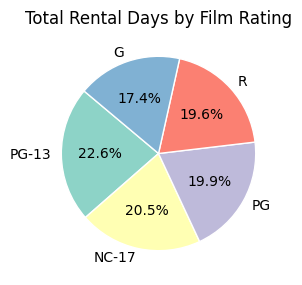

In [24]:
import matplotlib.pyplot as plt

sizes = rating_total_days["total_days_rented"].values
labels = rating_total_days["rating"].values
colors = plt.cm.Set3(range(len(labels))) 

plt.figure(figsize=(3,3))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)

plt.title('Total Rental Days by Film Rating')
plt.tight_layout()

plt.savefig("total_rental_days_pie.png", dpi=100)

plt.show()




## Task 2 - graphs

### a) Who are our top 5 customers by total spend? The Manager wants to know so that they can reward them
### with special offers. Create a bar chart showing the top 5 customers by total spend.

In [25]:
duckdb.sql("SELECT c.customer_id, c.first_name || ' ' || c.last_name AS customer_name, SUM(p.amount) AS total_spend FROM customer c LEFT JOIN payment p ON c.customer_id = p.customer_id GROUP BY c.customer_id, customer_name ORDER BY total_spend DESC, customer_name ASC LIMIT 5" ).df()

,customer_id,customer_name,total_spend
0,526,KARL SEAL,221.55
1,148,ELEANOR HUNT,216.54
2,144,CLARA SHAW,195.58
3,178,MARION SNYDER,194.61
4,137,RHONDA KENNEDY,194.61


### ASSIGNING TO A VARIABALE AND TRASFER TO "REFINED" SCHEMA 

In [26]:
top_customers = duckdb.sql("SELECT c.customer_id, c.first_name || ' ' || c.last_name AS customer_name, SUM(p.amount) AS total_spend FROM customer c LEFT JOIN payment p ON c.customer_id = p.customer_id GROUP BY c.customer_id, customer_name ORDER BY total_spend DESC, customer_name ASC" ).df()

In [27]:
duckdb.sql("""
            CREATE OR REPLACE TABLE refined.top_customers_total_spend AS 
           SELECT * FROM top_customers 
""")

### Horizontal Bar Chart for Top Five Customers

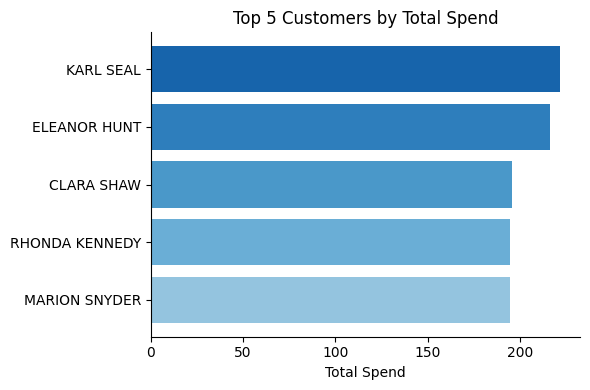

In [28]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

top5_customers = top_customers.sort_values(by="total_spend", ascending=False).head(5)

top5_customers_sorted = top5_customers.sort_values(by="total_spend", ascending=True)

names = top5_customers_sorted["customer_name"]
totals = top5_customers_sorted["total_spend"]

plt.figure(figsize=(6,4))
ax = plt.gca()

num_bars = len(names)
colors = cm.Blues(np.linspace(0.4, 0.8, num_bars))  

bars = ax.barh(names, totals, color=colors)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("Total Spend")
plt.title("Top 5 Customers by Total Spend")
plt.tight_layout()

plt.savefig("top_5_customers.png", dpi=100, bbox_inches='tight')
plt.show()




### b) How much money does each film category bring in? Make a bar chart showing total revenue per film category.

In [29]:
duckdb.sql("SELECT c.name AS category_name, SUM(p.amount) AS total_revenue FROM category c LEFT JOIN film_category fc ON c.category_id = fc.category_id LEFT JOIN film f ON fc.film_id = f.film_id LEFT JOIN inventory i ON f.film_id = i.film_id LEFT JOIN rental r ON i.inventory_id = r.inventory_id LEFT JOIN payment p ON r.rental_id = p.rental_id GROUP BY category_name ORDER BY total_revenue DESC;").df()

,category_name,total_revenue
0,Sports,5314.21
1,Sci-Fi,4756.98
2,Animation,4656.30
3,Drama,4587.39
4,Comedy,4383.58
5,Action,4375.85
6,New,4351.62
7,Games,4281.33
8,Foreign,4270.67
9,Family,4226.07


### ASSIGNING TO A VARIABALE AND TRASFER TO "REFINED" SCHEMA 

In [30]:
category_total_revenue = duckdb.sql("SELECT c.name AS category_name, SUM(p.amount) AS total_revenue FROM category c LEFT JOIN film_category fc ON c.category_id = fc.category_id LEFT JOIN film f ON fc.film_id = f.film_id LEFT JOIN inventory i ON f.film_id = i.film_id LEFT JOIN rental r ON i.inventory_id = r.inventory_id LEFT JOIN payment p ON r.rental_id = p.rental_id GROUP BY category_name ORDER BY total_revenue DESC;").df()

In [31]:
duckdb.sql("""
            CREATE OR REPLACE TABLE refined.category_revenue AS SELECT *
           FROM category_total_revenue

""")

### Bar chart for Category Revenue

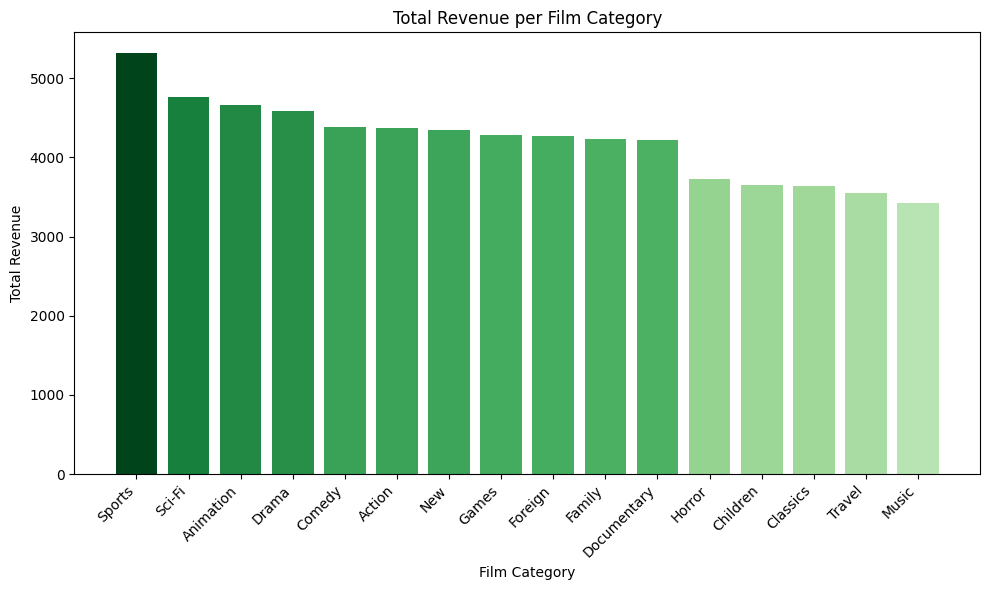

In [37]:
import duckdb
import matplotlib.pyplot as plt
import matplotlib.cm as cm

df = duckdb.sql("SELECT * FROM refined.category_revenue").df()

norm = (df["total_revenue"] - df["total_revenue"].min()) / (df["total_revenue"].max() - df["total_revenue"].min())
norm = 0.3 + 0.7 * norm  # scale to [0.3, 1]

colors = cm.Greens(norm)

plt.figure(figsize=(10,6))
plt.bar(df["category_name"], df["total_revenue"], color=colors)
plt.xlabel("Film Category")
plt.ylabel("Total Revenue")
plt.title("Total Revenue per Film Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("category_revenue_chart.png", dpi=300)
plt.show()



In [34]:
duckdb.sql("SHOW TABLES FROM refined;").df()

,name
0,category_revenue
1,customer_rental_duration
2,rating_total_days
3,top_customers_total_spend


In [36]:
duckdb.sql("DESCRIBE refined.category_revenue;").df()

,column_name,column_type,null,key,default,extra
0,category_name,VARCHAR,YES,None,None,None
1,total_revenue,DOUBLE,YES,None,None,None
